In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import convolve

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def groupproject_IRFsimulate(amplitudes, lifetimes, acquisitiontime, irfwidth):
    bg = 10  # number of background counts per second, keep at 10
    if irfwidth == 0:
        irfwidth = 1e-8

    # check that each amplitude has a corresponding lifetime
    if len(amplitudes) != len(lifetimes):
        return

    # create empty vector to store decay data
    puredecay = np.zeros(381)

    # normalise amplitudes, just in case they didn't initially sum to 1
    amplitudes = amplitudes / np.sum(amplitudes)

    # generate a multiexponential decay starting at 1 at t=0
    # using the supplied amplitudes and lifetimes
    for i in range(381):
        t = (1/19) * (i - 1)  # each bin is (1/19) ns, starting at t=0
        for j in range(len(amplitudes)):
            puredecay[i] += amplitudes[j] * np.exp(-t / lifetimes[j])

    # generate the IRF, centred at b
    b = 10 / 19
    w = irfwidth
    irfraw = np.zeros(381)
    for i in range(381):
        t = (i - 20) * (1 / 19)
        irfraw[i] = np.exp(-4 * np.log(2) * (t - b)**2 / (w**2))

    # convolute the IRF and decay and trim to 381 bins
    Iconvol = convolve(puredecay, irfraw, mode='full')[:381]

    # we do our measurements at 2500 counts per second
    # calculate how many fluorescence counts per second this corresponds to
    # i.e. subtract background from total counts
    fluorate = 2500 - bg

    # calculate total number of fluorescence photons counted in measurement
    totalfluorescence = fluorate * acquisitiontime

    # now scale the multiexponential decay so it contains this many counts
    noiseless = totalfluorescence * Iconvol / np.sum(Iconvol)

    # and add on 'bg' counts per second spread evenly across all bins
    noiseless = noiseless + (bg * acquisitiontime / 381)

    # finally add Poisson noise to each bin
    noisydecay = np.random.poisson(noiseless)

    # and tidy up output with a time axis
    output = np.zeros((381,2))
    for i in range(381):
        output[i, 0] = (i - 1) * (1 / 19)
        output[i, 1] = noisydecay[i]

    return output


In [32]:
from scipy import stats
from scipy.special import erf, erfinv
def sim_decay_photon_count_multiple(sim_param, Tau, N, n_decay):
    # n_decay is the number of decay to simulate

    # IRF parameters
    t0 = sim_param[0]    # offset in ns
    s = sim_param[1]    # standard deviation of Gaussian function in ns

    # Acquisition parameters
    n = sim_param[2]       # number of bits coding the TAC n = 8 --> 256 bins
    T = sim_param[3]      # Acquisition window 0-T in ns
    R = sim_param[4]      # Repetition rate of the laser in MHz
    Ap = sim_param[5]      # Afterpulsing in # --> background in TCSPC

    # Generating the arrival times
    if Tau > 0:
        #generate uniform random distribution between 0 and 1
        u_f = np.random.rand(N, n_decay)
        #arrival time in exponential distribution
        #1/(1-u_f) is inverse transform mapping
        t_f = Tau * np.log(1. / (1 - u_f))
    else:
        t_f = np.zeros((N, n_decay))

    if t0 <= 0 or s <= 0:
        t_irf = np.zeros((N, n_decay))
    else:
        u_irf = np.random.rand(N, n_decay)
        t_irf = t0 - s * np.sqrt(2) * erfinv(erf(t0 / s) - 2 * u_irf )

    t_tot = t_f + t_irf

    # Incomplete decays
    T_rep = 1000 / R
    t_tot = np.mod(t_tot, T_rep)

    # Afterpulsing background
    N_bg = np.ceil(Ap / 100 * N)
    t_Ap = T * np.random.rand(int(N_bg), n_decay)
    t_tot = np.vstack((t_tot, t_Ap))

    # Histogramming
    t = np.linspace(0, T, 2 ** n + 1)
    t = t[:-1]
    phot_number = np.histogram(t_tot, bins=np.concatenate((t, [t[-1] + t[1] - t[0]])))[0]

    if Display == 1:
        # Displaying
        plt.figure()
        plt.semilogy(t, phot_number)
        plt.xlabel('Time (ns)')
        plt.ylabel('Photon counts')
        plt.title('N = {} photons, Tau = {} ns'.format(N, Tau))

        plt.figure()
        plt.plot(t, phot_number)
        plt.xlabel('Time (ns)')
        plt.ylabel('Photon counts')
        plt.title('N = {} photons, Tau = {} ns'.format(N, Tau))

    return t, phot_number

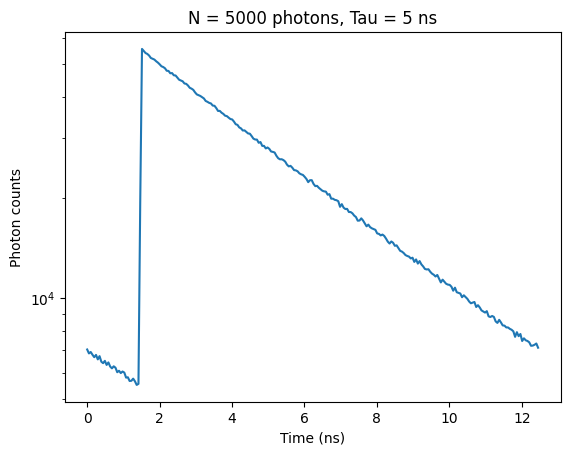

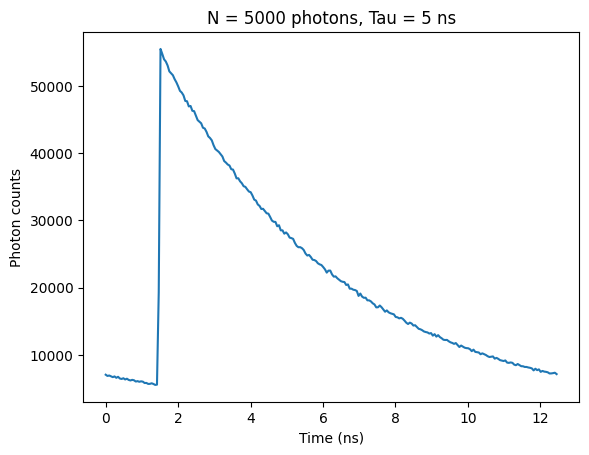

In [33]:
# Change acquisition parameters --------------------
R = 80      #Repetition rate of the laser in MHz units
T = 12.5    # Acquisition window 0-T in ns units
n = 8       # number of bits coding the TAC n = 8 --> 256 bins
Ap = 5      # Afterpulsing in # --> background in TCSPC

# Change parameters for IRF-----------------------------
t0 = 1.5;    # offset in ns units
s = 0.0001;    # standard deviation of Gaussian function in ns units
N_irf = 1e8; # MAXIMUM 10^8! (150,000 for 256 bins to get close to 16 bit histograms)
N = 5000     # no. of photons
n_decay = 1024 #the number of decay to simulate
Tau = 5      #lifetime /ns
sim_param = [t0, s, n, T, R, Ap]
Display = 1
t,n_photon = sim_decay_photon_count_multiple(sim_param, Tau, N, n_decay)

In [35]:
np.sum(n_photon)/1240


4335.4838709677415

In [13]:
np.arange(0,381*(1+1/19),1/19)

array([0.00000000e+00, 5.26315789e-02, 1.05263158e-01, ...,
       4.00894737e+02, 4.00947368e+02, 4.01000000e+02])

In [3]:
data=groupproject_IRFsimulate([0.8,0.2],[0.4,3],600,0)

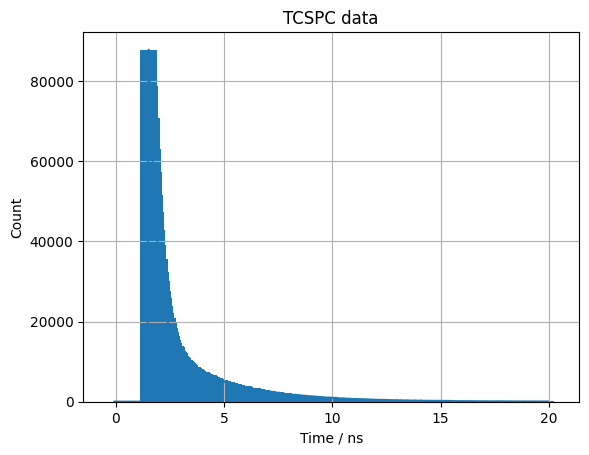

In [10]:
#xpoints = np.linspace(0,1,100)

plt.figure()
plt.title(r'TCSPC data')
plt.xlabel(r'Time / ns')
plt.ylabel(r'Count')
plt.grid()

plt.bar(data[:, 0],data[:, 1])
#plt.plot(data[:, 0],data[:, 1])
#plt.legend(loc="best")

In [37]:
np.random.exponential(1/2,50)

array([0.22864159, 0.22077719, 0.84688765, 0.69983281, 0.70848224,
       0.13367117, 0.83444417, 0.33587319, 0.62282282, 0.26526283,
       0.56078449, 0.11662616, 0.60730793, 0.6375458 , 0.92479759,
       0.06365873, 0.18830002, 0.06960135, 0.02234228, 0.08742897,
       0.13892621, 0.52460033, 0.33226664, 0.54704487, 1.31740779,
       0.22827641, 0.42791327, 0.05927466, 0.50955812, 0.20437457,
       0.00259432, 0.68094438, 0.16879466, 1.49976289, 0.4466555 ,
       0.1687063 , 0.24426588, 0.12967318, 0.24839811, 1.70679836,
       2.19106716, 0.00271114, 0.01737132, 0.1712533 , 0.50098768,
       0.47940139, 0.29940841, 0.51787951, 0.37302236, 0.40593018])

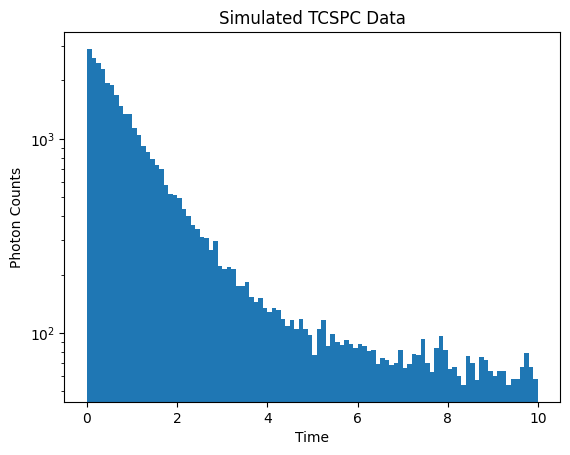

In [102]:
def simulate_multi_exponential_decay(t, decay_time_constants, amplitudes):
    decay_profile = np.zeros_like(t)
    for decay_time, amplitude in zip(decay_time_constants, amplitudes):
        decay_profile += amplitude * np.exp(-t / decay_time)
    return decay_profile

# Simulation parameters
t = np.linspace(0, 10, 1000)  # Time points
decay_time_constants = np.array([1.0, 20]) # Decay time constants for each component
amplitudes = np.array([0.6, 0.4])  # Amplitudes for each component

N = 50000  # Number of photons to simulate

# Simulate TCSPC data
timestamps = []
for _ in range(N):
    decay_time = np.random.choice(decay_time_constants, p=amplitudes/np.sum(amplitudes))
    timestamp = np.random.exponential(decay_time)
    timestamps.append(timestamp)

# Histogram the simulated timestamps
counts, bins, _ = plt.hist(timestamps, bins=100, range=(0, np.max(t)))

# Convert counts to photon counts per time bin
bin_width = bins[1] - bins[0]
photon_counts = counts / (N * bin_width)

# Plot the simulated TCSPC data
plt.xlabel('Time')
plt.ylabel('Photon Counts')
plt.yscale('log')
plt.title('Simulated TCSPC Data')
plt.show()

### Fourier Transform

Text(0.5, 1.0, 'FFT of TCSPC Intensity decay')

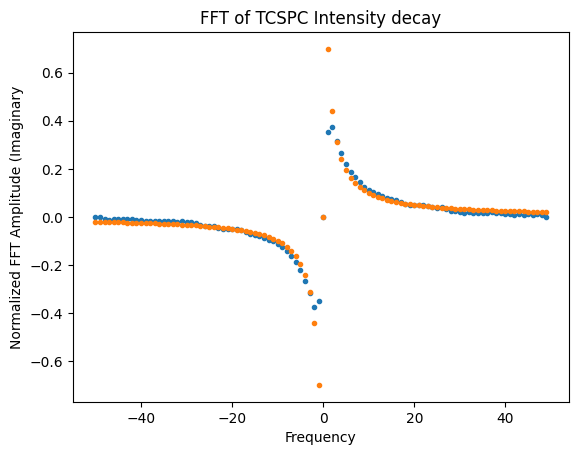

In [126]:
freq = np.fft.fftfreq(len(counts), d=1./len(counts))
phasor = np.fft.fft(counts)/np.sum(counts) #Fourier Transform to obtain phasor
plt.plot(freq,-np.imag(phasor),'.')
# plt.plot(freq, amplitudes[0]/decay_time_constants[0]**2/((freq)**2+(1/decay_time_constants[0])**2)
# +amplitudes[1]/decay_time_constants[1]**2/((freq)**2+(1/decay_time_constants[1])**2),'.')
plt.plot(freq, amplitudes[0]*freq/((freq)**2+(1/decay_time_constants[0])**2)
+amplitudes[1]*freq/((freq)**2+(1/decay_time_constants[1])**2),'.')
plt.xlabel('Frequency')
plt.ylabel('Normalized FFT Amplitude (Imaginary')
plt.title('FFT of TCSPC Intensity decay')

In [80]:
(np.fft.fft(counts)/np.sum(counts))[omega==0.48]

array([0.04156161-0.00157355j])

In [121]:
def phi(tau,omega):
    '''compute phi of phasor from lifetime tau and laser modulation/FT angular frequency omega'''
    return np.arctan(omega*tau)

def m(tau,omega):
    '''compute modulation m of phasor from lifetime tau and laser modulation/FT angular frequency omega'''
    return np.sqrt(1/(1+(omega*tau)**2))

def phasor_coordinate(tau,omega):
    '''convert polar cooridnates m and phi to Cartesian x and y
    output: [x array, y array]'''
    return np.array([m(tau,omega)*np.cos(phi(tau,omega)),m(tau,omega)*np.sin(phi(tau,omega))])

In [120]:
phasor_coordinate(decay_time_constants,omegas)[0]

array([2.47045230e-02, 6.33217299e-05])

In [122]:
freq

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49., -50., -49., -48., -47., -46.,
       -45., -44., -43., -42., -41., -40., -39., -38., -37., -36., -35.,
       -34., -33., -32., -31., -30., -29., -28., -27., -26., -25., -24.,
       -23., -22., -21., -20., -19., -18., -17., -16., -15., -14., -13.,
       -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,
        -1.])

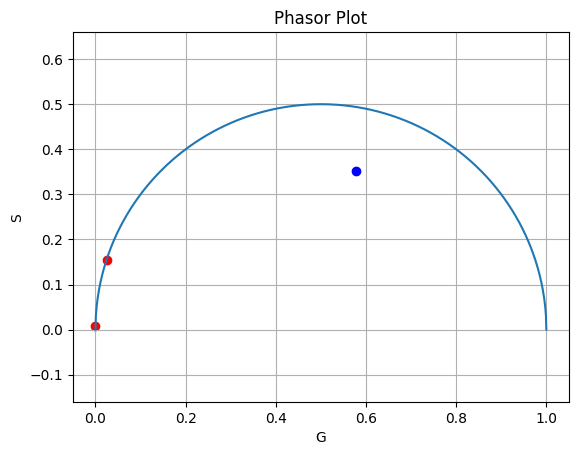

In [118]:
# Fourier transform of the TCSPC data
decay_profile = simulate_multi_exponential_decay(t, decay_time_constants, amplitudes)
sr = len(counts)/10 #no. of samples/time (ns)
freq = np.fft.fftfreq(len(counts), d=1./len(counts))
phasor = (np.fft.fft(counts)/np.sum(counts))[freq==1]

# Phasor plot
x = np.linspace(0,1,1000)
y_circ = np.sqrt(0.5**2-(x-0.5)**2)
omegas = np.full(2,2*np.pi)
plt.figure()
plt.scatter(np.real(phasor), -np.imag(phasor), c='blue')
plt.scatter(phasor_coordinate(decay_time_constants,omegas)[0],
phasor_coordinate(decay_time_constants,omegas)[1], c='red')

plt.plot(x,y_circ) #universal circle
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('G')
plt.ylabel('S')
plt.title('Phasor Plot')
plt.axis('equal')
plt.grid()